## Phase 3 Project Submission - Diabetes or Bust

* Student name: Eva Mizer
* Student pace: Flex
* Scheduled project review date/time: Tuesday, Jan 10th, 10:00am via Zoom
* Instructor name: Morgan Jones
* Blog post URL: https://www.blogger.com/blog/posts/4845670283059937521?pli=1


## Introduction

### Business Case 

#### Stake Holders:
* Medical facilities such as primary care physician offices, or even other medical care facilities such as convenient care facilities, urgent care facilities, and hospitals. While these are my primary stake holders, it would be within the rhealm of possibility that this model could be used by insurance companies.

#### Busniess Problem/Solution:
* When receiving a new patient or even reviewing updated information for a current patient, doctors and nurses would be able to input the basic data points needed for the model to see if a patient might have diabetes (diagnosed or not). 

#### Performance Goals:
* **My goal is to make predictions with my model as accurately as possible while maximizing true positive cases. We will be setting our thresholds at 80% for both accuracy and recall.** 

* Since this is just a quick tool to screen if someone is likely to have diabetes, it would be better to overdiagnose positive cases than to underdiagnose. Undiagnosed diabetes can have pretty serious health complications if left untreated, so overdiagnosing (high recall for true positives even at the expense of true negatives recall) would be advised. Doctors can order more specific tests to determine if someone does indeed have diabetes. 

* **It should be noted that this model does not distinguish between Type-1 and Type-2 diabetes.**

### Overview 


#### The Data
The [data]("https://www.kaggle.com/datasets/prosperchuks/health-dataset") we are using today is from the [Behavioral Risk Factor Surveillance System (BRFSS)](https://www.kaggle.com/datasets/cdc/behavioral-risk-factor-surveillance-system"), a health-related telephone survey that is collected annually by the CDC. This dataset is a balanced subset of the original dataset of 441,455 Americans on health-related risk behaviors, chronic health conditions, and the use of preventative services from 2015, made available on Kaggle. These features are either questions directly asked of participants, or calculated variables based on individual participant responses. While the original dataset had over 330 features and over 400,000 entries, this subset has 21 feature variables and 70,692 entries. Because the subset is so large, we will be take a 10% sample of that subset for ease of use. 

**It should be noted that this dataset does not distinguish between Type-1 and Type-2 diabetes.**

#### Scoring Metric
* Roc_Auc and recall will be used as the scoring metric for our models.
* We want to maximize our true positives in recall.

##### 1. [Import Libraries and Data](#Import_Libraries)
##### 2. [Clean and Inspect the Data](#Clean)
##### 3. [Data Prep](#Dataprep)
* Choose target features (diabetes/all others)
* Split into X and Y
* Split for Training and Testing
* OHE

##### 4. [Models and refinement](#Modeling) 
* Classification model report
* Analysis

##### 5. [Final Model Selection](#Final)

##### 6. [Business Recommendations](#business)

##### 7. [Next Steps](#next)

## 1. Import the Libraries <a id='Import_Libraries'></a>

In [1]:
# IMPORT ALL THE THINGS!

#Basic Goodies
import numpy as np 
import pandas as pd
import xgboost 
from matplotlib import pyplot as plt
from sklearn.utils import resample

#Basic Classifiers
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from logitboost import LogitBoost
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Lasso



#model selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import statsmodels.api as sm

#Preprocessing Tools
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#Model tuning methods
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

#For checking precision, etc.
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix, precision_score, plot_roc_curve, roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns

#Because I hate pink warnings
import warnings
warnings.filterwarnings('ignore')

### Meet the Data
Before we get started, let's take a look at the dataset itself. We have mostly binary features, with a few categorical and one scaled. 

#### Target Feature:
* **Diabetes:** Binary. Does patient have diabetes?
    * 0 = no 
    * 1 = yes

#### Predictive Features:
* **Age:** Categorical. 13-level age category, 1-13 in sets of 5. 
    * 1 = 18-24 
    * 2 = 25-29
    * 3 = 30-34
    * 4 = 35-39
    * 5 = 40-44
    * 6 = 45-49
    * 7 = 50-54
    * 8 = 55-59
    * 9 = 60-64
    * 10 = 65-69
    * 11 = 70-74
    * 12 = 75-79
    * 13 = 80 or older
* **Sex:** Binary. Patient's gender.
    * 1: male; 
    * 0: female
* **HighChol:** Binary. 
    * 0 = no high cholesterol 
    * 1 = high cholesterol
* **CholCheck:** Binary.
    * 0 = no cholesterol check in 5 years 
    * 1 = yes cholesterol check in 5 years
* **BMI:** Numerical (non-binary). Patients BMI
* **Smoker:** Binary. Has patient smoked at least 100 cigarettes in their entire life? 
[Note: 5 packs = 100 cigarettes] 
    * 0 = no 
    * 1 = yes
* **HeartDiseaseorAttack:**  Binary. Coronary heart disease (CHD) or myocardial infarction (MI)     
    * 0 = no 
    * 1 = yes
* **PhysActivity:** Binary. Physical activity in past 30 days - not including job    
    * 0 = no 
    * 1 = yes
* **Fruits:** Binary. Consume Fruit 1 or more times per day    
    * 0 = no 
    * 1 = yes
* **Veggies:** Binary. Consume Vegetables 1 or more times per day    
    * 0 = no 
    * 1 = yes
* **HvyAlcoholConsump:** Binary. (adult men >=14 drinks per week and adult women>=7 drinks per week) 
    * 0 = no 
    * 1 = yes
* **GenHlth:** Categorical. Patients asked to rank their general your health on a scale of 1-5. 
    * 1 = excellent 
    * 2 = very good 
    * 3 = good 
    * 4 = fair 
    * 5 = poor
* **MentHlth:** Numerical. Number of days of poor mental health in the last 30 days on a scale of 1-30 days
* **PhysHlth:**  Numerical. Number of days of physical illness or injury days in past 30 days scale 1-30 days
* **DiffWalk:** Binary. Does patient have serious difficulty walking or climbing stairs?
    * 0 = no 
    * 1 = yes
* **Stroke:** Binary. Has patient ever experienced a stroke?
    * 0 = no 
    * 1 = yes
* **HighBP:** Binary. Does patient have high blood pressure?
    * 0 = no 
    * 1 = yes
* **Diabetes:** Binary. Does patient have diabetes?
    * 0 = no 
    * 1 = yes

Now let's take a look at each feature, how many entries we have, how many nulls, and what type it is, etc. 

In [9]:
# Load the diabetes dataset
data = pd.read_csv('data/diabetes_data.csv') 
# Print the dimensions of data
print(data.shape)
# Check out the info for the dataframe
print(data.info())


(70692, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   70692 non-null  float64
 1   Sex                   70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   HeartDiseaseorAttack  70692 non-null  float64
 7   PhysActivity          70692 non-null  float64
 8   Fruits                70692 non-null  float64
 9   Veggies               70692 non-null  float64
 10  HvyAlcoholConsump     70692 non-null  float64
 11  GenHlth               70692 non-null  float64
 12  MentHlth              70692 non-null  float64
 13  PhysHlth              70692 non-null  float64
 14  DiffWalk              70692 non-null  float64
 15  Stroke 

In [10]:
# Show the first 5 rows
data.head()

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0
4,8.0,0.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


Cool! Looks like a nice descriptive dataset with some columns that will need to be reformatted and/or dummied out, and a good hunk of entries to work with. 

Now let's explore a little more at what kind of unique values we are working with and how many Nans we have.

In [11]:
#How many unique values per column?
print(data.nunique())

#How many Nans, computer?
print("There are", data.isna().sum().sum(), "Nans!")

Age                     13
Sex                      2
HighChol                 2
CholCheck                2
BMI                     80
Smoker                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
GenHlth                  5
MentHlth                31
PhysHlth                31
DiffWalk                 2
Stroke                   2
HighBP                   2
Diabetes                 2
dtype: int64
There are 0 Nans!


So it looks like we will need to dummy out Age, BMI, GenHlth, MentHlth, and PhysHlth. Everything else is already in 0/1 format and, even better, have no Nans!! 

Let's see the correlation between Diabetes and the other columns. 

In [12]:
#correlation values
data[data.columns[1:]].corr()['Diabetes'][:].sort_values(ascending=False)

Diabetes                1.000000
GenHlth                 0.407612
HighBP                  0.381516
BMI                     0.293373
HighChol                0.289213
DiffWalk                0.272646
PhysHlth                0.213081
HeartDiseaseorAttack    0.211523
Stroke                  0.125427
CholCheck               0.115382
MentHlth                0.087029
Smoker                  0.085999
Sex                     0.044413
Fruits                 -0.054077
Veggies                -0.079293
HvyAlcoholConsump      -0.094853
PhysActivity           -0.158666
Name: Diabetes, dtype: float64

Because this dataset has been balanced for diabetes, we should have equal amounts for both having diabetes and not. Let's see:

In [13]:
#How any 0 and 1 values in this dataset for Diabetes?
data['Diabetes'].value_counts()

1.0    35346
0.0    35346
Name: Diabetes, dtype: int64

Checks out! Let's see if there are any duplicates.

In [ ]:
#Find and add up all the dumplicates
data.duplicated().sum()

So it looks like about 10% of the data is duplicates, but since there is no ID to check, we can't be certain that these duplicates are accidental duplicates, or if they are just 6672 people roughly in the same age group and lifestyle.

## 2. Clean and Inspect the Data <a id='Clean'></a>

This dataset doesn't actually need much cleaning. There are no nans, I like the titles and their easy legibility, and most of the data is already in 1/0 format for easy fun modeling. 

Still, just for curiosity, let's check out the values of the columns we will be OHE-ing. 


In [14]:
#Find unique values for the categories we intend to OHE
print("Age: ", sorted(data['Age'].unique()))
print("GenHlth: ", sorted(data['GenHlth'].unique()))

Age:  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0]
GenHlth:  [1.0, 2.0, 3.0, 4.0, 5.0]


Ok, so when I look at this, I'm thinking that the OHE of BMI could make our model *really, really* slow, but it's one of our heavy correlation hitters, so we will likely be better off with it. Still, I might try to see how much it affects the end result of the model and if we actually need it. 

Because this dataset is so large, I want to take a smaller sample of it to work with, since it will be more efficient than using the whole dataset, but still be statistically representative. 

In [15]:
small_data = data.groupby('Diabetes').apply(pd.DataFrame.sample, frac=0.5, random_state=42).reset_index(drop=True)

In [ ]:
#Close (but not exact) correlation levels? YES!
small_data[small_data.columns[1:]].corr()['Diabetes'][:].sort_values(ascending=False)

Great! Now let's check for ***multicollinearity on the new, smaller data subset!***

### Visuals and EDA

#### Multicollinearity

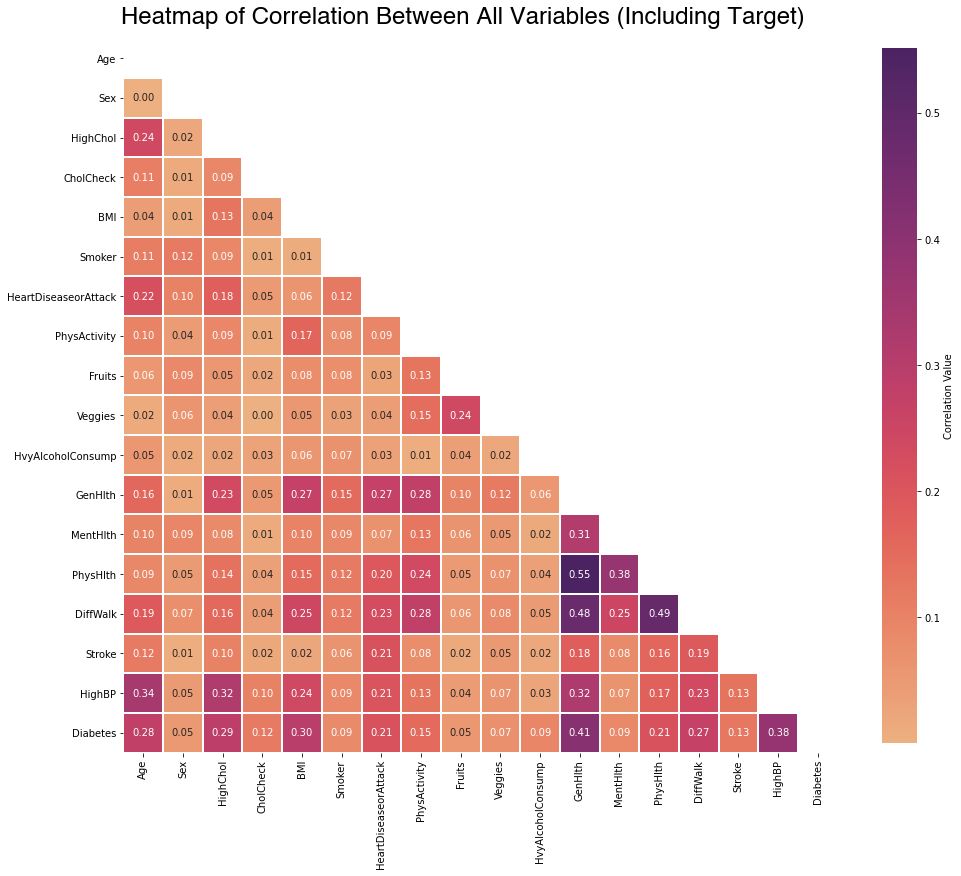

In [61]:
#Check for multicollinearity visually:
corr = small_data.corr().abs()

fig, ax=plt.subplots(figsize=(16,16))
matrix = np.triu(corr)
cbar_kws={"label": "Correlation Value", "shrink":0.8}
heatmap = sns.heatmap(data = corr, cmap='flare', linewidths = 1, square= True,  ax=ax, annot=True, mask=matrix, fmt= ".2f", cbar_kws=cbar_kws) 
fig.suptitle('Heatmap of Correlation Between All Variables (Including Target)', fontsize=24, y=.84, x = .42, fontname='Helvetica');
heatmap;

##### Multicollinearity Summary

Our top correlating features with Diabetes are 
* **GenHlth**
* **HighBP**
* **BMI**
* **HighChol**
* **Age**
* **DiffWalk**

Since none of the values are over .7, we can keep them all!

Let's take a look at how they relate to someone with and without Diabetes, among with some of the other top 10. Let's explore some of these visually, but first, let's make a little box plot cheat sheet to keep things simple!

#### Diabetes Box Plot Functions

In [ ]:
def dia_box(X, y, y_title, plot_title):
    ax = sns.barplot(x=X, y=y, hue='Diabetes', data=small_data, palette="flare")
    ax.figure.set_size_inches(20,10)
    ax.set_ylabel(y_title, fontsize=16)
    ax.set_title(plot_title, fontsize=20)

def dia_box_simple(X, y, y_title, plot_title):
    ax = sns.barplot(x=X, y=y, data=small_data, palette="flare")
    ax.figure.set_size_inches(20,10)
    ax.set_ylabel(y_title, fontsize=16)
    ax.set_title(plot_title, fontsize=20)
    
def mini_dia_box(y, y_title, plot_title):
    mean_df = small_data[['Diabetes', y]].groupby('Diabetes', as_index=False).mean()
    print(mean_df)

    #Bar plot to visualize!
    ax = sns.barplot(x='Diabetes', y=y, data=mean_df, palette="flare")
    ax.figure.set_size_inches(6,6)
    ax.set_ylabel(y_title)
    ax.set_title(plot_title)

#### General Health and Age vs Diabetes

In [ ]:
#Make a boxplot of General Health and Age vs Diabetes using our function
dia_box("Age", "GenHlth", 'General Health Rating', 'General Health Rating per Diabetes Status')


In [ ]:
mini_dia_box('GenHlth', 'General Health Rating', 'General Health Rating per Diabetes Status')

Here we see a theme stating to emerge where no matter the age group, those that suffer from diabetes also fair worse on their General Health. Overall, diabetics have about **39% worse general health ratings** than those that are not diabetic. 

#### High Blood Pressure and Age vs Diabetes

In [ ]:
#Make a boxplot of High Blood Pressure and Age vs Diabetes using our function
dia_box("Age", "HighBP", 'Blood Pressure Score', 'High Blood Pressure per Diabetes Status')

In [ ]:
mini_dia_box('HighBP', 'Prevelence of High Blood Pressure', 'Prevelence of High Blood Pressure per Diabetes Status')

Overall, those with diabetes have about ***99% higher prevelence*** of high blood pressure than those that do not.

#### BMI and Age vs Diabetes

In [ ]:
#Make a boxplot of High Blood Pressure and Age vs Diabetes using our function
dia_box("Age", "BMI", 'BMI Score', 'BMI per Diabetes Status')

In [ ]:
mini_dia_box('BMI', 'BMI Score', 'Average BMI Score per Diabetes Status')

On average, BMIs are about **15% higher** on those with diabetes.

#### High Cholesterol and Age vs. Diabetes Status

In [ ]:
dia_box("Age", "HighChol", 'Prevelence of High Cholesterol', 'Prevelence of High Cholesterol per Diabetes Status')

In [ ]:
#Find average for parameter for diabetes status 
mini_dia_box("HighChol", 'Prevelence of High Cholesterol', 'Prevelence of High Cholesterol per Diabetes Status')

Overall, the prevelence of high cholesterol was **75% higher** in those with diabetes than those without. 

#### Diabetes Status vs Age

Here we can plainly see a gradual incline of the prevelence of diabetes as patients get older. There ia slight decline at the end, which might be explained by the lower life expectancy of those with diabetes [(77 for men, 81 for women)](https://www.diabetes.co.uk/diabetes-life-expectancy.html)

In [ ]:
dia_box_simple("Age", "HighChol", 'Prevelence of Diabetes', 'Prevelence of Diabetes per Age Group')


#### Mental Health and Age vs Diabetes

While being the 10th most correlated value, this is something I'd really like to visualize. 

In [ ]:
dia_box("Age", "MentHlth", 'Number of Poor Mental Health Days in Past 30 Days', 'Poor Mental Health Days per Diabetes Status')


This one I find particulary telling and concerning. While some may specilate that someone may be more likely to have diabetes if they have poorer mental health, I would argue that it could go both ways. If you have diabetes, it would be one more stressor to add to your concerns, but having poor mental health could lead to poor physical health habits that could lead the way for diseases such as diabetes. 



#### *Outliers*
*While it appears that we have a lot of outliers in our data, I will be keeping them in. These ratings are based on the patients own opinion/perception of how they feel, and if a lot of the outliers end up belonging to one outcome (diabetes vs not), it wouldn't be pertinant to remove them.*

In [ ]:
# Let's try a box and whiskers plot to get a better visual on outliers
sns.set_theme(style="ticks", palette="pastel")

# Draw a nested boxplot to show Age vs Poor Mental Health Days with Diabetes status indicated in green
sns.boxplot(x="Age", y="MentHlth",
            hue="Diabetes", palette="flare",
            data=small_data)
sns.despine(offset=10, trim=True)

One thing I do think is really interesting from this is that while there seems to consistently be outliers for poor mental health days throughout the age groups, the oldest age groups average about 55% fewer poor mental health days than the youngest group, even though they have the highest rates of diabetes. (See below) This could be because they have less stressors in their life that would be present in those who are younger with school/work/home/family obligations and responsibilities. 

Although those in the youngest category (1.0) had over **15 times less prevelence in diabetes** than the age of top diabetes prevelence (11.0), yet they suffered from about **46% more poor mental health days (3.95 vs 2.70**).

In [ ]:
ment_mean = small_data[['Age', 'MentHlth','Diabetes']].groupby('Age', as_index=False).mean()
print(ment_mean)

##### Overall Poor Mental Health Days per Diabetes status

As we can see below, in regards to the whole population, those with diabetes reported roughly **45% more poor mental health days than those without diabetes.**

In [ ]:
mini_dia_box('MentHlth', 'Mean Poor Mental Health Days', 'Average Poor Mental Health Days per Diabetes Status')

#### Difficulty Walking vs. Diabetes Status

In [ ]:
dia_box("Age", "DiffWalk", 'Walking Difficulty Rating', 'Walking Difficulty Rating per Diabetes Status')


I think it's so fascinating (though perhaps not too suprising), that the incline for those having difficulty walking increases at a much slower and gradual pace for those without diabetes than those with.

In [ ]:
mini_dia_box('DiffWalk', 'Prevelence of Difficulty Walking', 'Prevelence of Difficulty Walking per Diabetes Status')

 Overall, regardless of age, patients are **2.7 times as likely to have difficulty walking if they have diabetes.**

## 3. Data Prep and Feature Engineering<a id='Dataprep'></a>

* Assign our x and y
* Split into training and testing data
* OHE-ing


In [71]:
#assign y to diabetes and drop it from the dataframe
y = small_data[['Diabetes']]
X = small_data.drop('Diabetes', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Let's check on our sample sizes!
print(y_train.value_counts(), '\n\n', y_test.value_counts())

Diabetes
1.0         14146
0.0         14130
dtype: int64 

 Diabetes
0.0         3543
1.0         3527
dtype: int64


### OHE-ing

#### OHE function

In [72]:
#select all object type/catagorical features and OHE them
data_cat = pd.DataFrame(X_train, columns=['Age', 'GenHlth'])

ohe = OneHotEncoder(drop='first', #to save from multicolinearty
                    sparse = False) #by default sparse=True #sparse is a way to efficiently store 1's and 0's when you have a ton of columns with 1's and 0's
#fitting it on the categories here and transforming it on said categories
ohe_data = ohe.fit_transform(data_cat)
#create dummies
ohe_data_df=pd.DataFrame(ohe_data,
                     columns=ohe.get_feature_names(),
                     index=data_cat.index)#make sure to pass an index

already_clean_data = X_train.drop(['Age', 'GenHlth'], axis=1)
#putting nums and dums dataframes back together, axis = 1 means it will be added from left to right
X_train = pd.concat([already_clean_data, ohe_data_df], axis=1)
#Check it out!
X_train.head()




,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,x0_8.0,x0_9.0,x0_10.0,x0_11.0,x0_12.0,x0_13.0,x1_2.0,x1_3.0,x1_4.0,x1_5.0
21824,1.0,1.0,1.0,30.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
24421,0.0,0.0,1.0,28.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
16313,0.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25627,1.0,1.0,1.0,27.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14170,0.0,1.0,1.0,34.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [73]:
#select all object type/catagorical features and OHE them
data_cat = pd.DataFrame(X_test, columns=['Age', 'GenHlth'])

ohe = OneHotEncoder(drop='first', #to save from multicolinearty
                    sparse = False) #by default sparse=True #sparse is a way to efficiently store 1's and 0's when you have a ton of columns with 1's and 0's
#fitting it on the categories here and transforming it on said categories
dums = ohe.fit_transform(data_cat)
#create dummies
dums_df=pd.DataFrame(dums,
                     columns=ohe.get_feature_names(),
                     index=data_cat.index)#make sure to pass an index

already_clean_data = X_test.drop(['Age', 'GenHlth'], axis=1)
#putting nums and dums dataframes back together, axis = 1 means it will be added from left to right
X_test = pd.concat([already_clean_data, dums_df], axis=1)
#Check it out!
X_test.head()




,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,x0_8.0,x0_9.0,x0_10.0,x0_11.0,x0_12.0,x0_13.0,x1_2.0,x1_3.0,x1_4.0,x1_5.0
19946,1.0,1.0,1.0,28.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2448,0.0,1.0,1.0,34.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
21135,1.0,1.0,1.0,36.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
21718,0.0,1.0,1.0,30.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4984,1.0,1.0,1.0,27.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


The one downside to OHE is that when it makes the new columns for the dummies, it assigns numbered x's instead of column names, so it becomes a huge pain to read. Here is a bit of help for this one:
* "Age" = x0
* "GenHlth" = x1

In [74]:
#Scaling before modeling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## 4. Models<a id='Modeling'></a>

We are going to play around with some different types of models, and tweak them and their hyperparameters to see how they fair. We will go in this order:
1. [Logistic Regression](#lr)
   * [GridSearch (GridSearchCV)](#gscv_lr) - To help find the best parameters to use in our model
    
2. [Random Forrest (RandomForrestClassifier)](#rf)
   * [GridSearch (GridSearchCV)](#gscv_dt) - To help find the best parameters to use in our model
3. [XG Boost](#xgboost)
   * [GridSearch (GridSearchCV)](#gscv_lr) - To help find the best parameters to use in our model
4. [LogitBoost](#logit)

### Fancy Functions : Model Results
But first, let's define what we would like to look at for each model we run to help us save on codespace and time.

In [22]:
def model_results(model):
    
    with plt.style.context('seaborn-talk'):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

        # Create Confusion Matrix for the test set
        plot_confusion_matrix(model, X_test, y_test, normalize = 'true', ax=ax1,  cmap = 'flare') 
        ax1.grid(False) 
        ax1.set_title("Train Confusion Matrix")

                
        # Create Roc curve for the test and train for TP and FP rates
        plot_roc_curve(model, X_train, y_train, ax=ax2, color='green', name ='Train ROC curve')
        plot_roc_curve(model, X_test, y_test, ax=ax2, color = 'blue', name ='Test ROC curve' )
        ax2.plot([0, 1], [0, 1], color='black', lw=2, linestyle='-')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
        plt.show()
        
        #Create a classification report
        y_pred = model.predict(X_test)
        print(classification_report(y_test, y_pred))
        
        
        ######***NEW LINE*** Print CV ROC_AUC score, and roc_auc score for test/train
        
        #Print CV ROC_AUC score
        roc_score_train_cv = cross_val_score(estimator=model, X=X_train,  y=y_train, 
                                        cv=StratifiedKFold(shuffle=True), scoring='roc_auc').mean()
        print(f"Mean Cross Validated Roc_Auc Score: {roc_score_train_cv :.0%}")  

        #print roc_auc for test and train 
        roc_score_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]) 
        print(f"Train Roc_Auc Score: {roc_score_train :.0%}")  

        roc_score_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        print(f"Test Roc_Auc Score: {roc_score_test :.0%}")  
        
        accuracy_train = model.score(X_train, y_train)
        accuracy_test = model.score(X_test, y_test)
        print(f"Train Accuracy Score: {accuracy_train :.0%}")
        print(f"Test Accuracy Score: {accuracy_test :.0%}")
        

### Model #1: Logistic Regression<a id='lr'></a>

First up is the classic Logistic Regression. We will start off with default settings (except for the random_state). 

Logistic regression is a popular classification method in statistics that is used to predict the **probability of an outcome** by fitting data to a logistic function.

For reference, Logistic Regression defaults are the following:

* **penalty**:{‘l1’, ‘l2’, ‘elasticnet’, None}, default=’l2’
* **dual**:bool, default=False
Dual or primal formulation. Dual formulation is only implemented for l2 penalty with liblinear solver. Prefer dual=False when n_samples > n_features.
* **tol**: float, default=1e-4
Tolerance for stopping criteria.

In [75]:
#basic logistic regression model
lr = LogisticRegression(random_state=42)

#Fit to information
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

After fitting to the data, we can now see the results of the baseline model. 

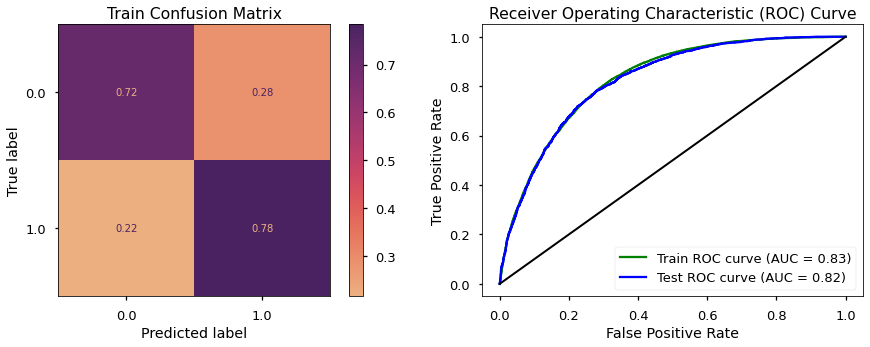

              precision    recall  f1-score   support

         0.0       0.77      0.72      0.74      3543
         1.0       0.73      0.78      0.76      3527

    accuracy                           0.75      7070
   macro avg       0.75      0.75      0.75      7070
weighted avg       0.75      0.75      0.75      7070

Mean Cross Validated Roc_Auc Score: 83%
Train Roc_Auc Score: 83%
Test Roc_Auc Score: 82%
Train Accuracy Score: 75%
Test Accuracy Score: 75%


In [76]:
model_results(lr)

So our CV Roc_Auc score is over 80%, which is pretty great out of the gate!

Overall, not too shabby, but since train scores are a smidge higher than test scores, it's evident that we are **slightly overfitting**.

##### Gridsearch Optimization for LogisticRegression Model <a id='gscv_lr'></a>
Let's see if we can tune our LR parameters to improve our scores. We will use Gridsearch to go thru these parameters to find the most optimal ones to use. 

In [77]:
param_grid_lr = {
    'max_iter': [5, 10, 20, 50],                      
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'newton-cholesky', 'saga'],  
    'class_weight': ['balanced'],
    'penalty':['l1', 'l2', 'elasticnet'],
    'random_state':[42]
}

In [78]:
lr_gs = GridSearchCV(estimator=lr, 
                             param_grid=param_grid_lr, 
                             verbose=1, cv=10, 
                             n_jobs=-1)
lr_gs.fit(X_train, y_train)


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 595 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    7.7s finished


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_iter': [5, 10, 20, 50],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'random_state': [42],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'newton-cholesky', 'saga']},
             verbose=1)

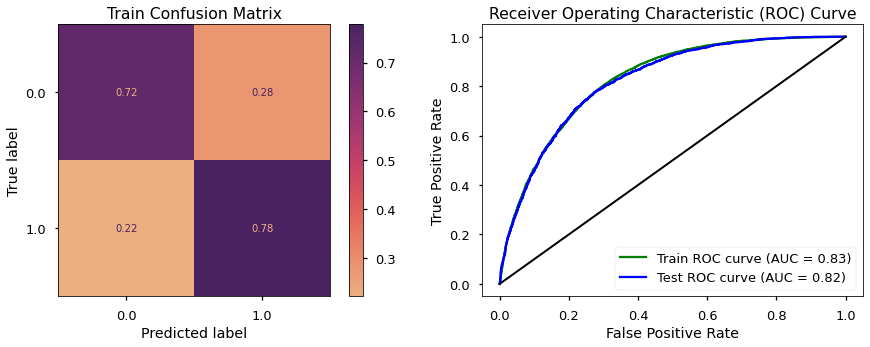

              precision    recall  f1-score   support

         0.0       0.77      0.72      0.74      3543
         1.0       0.74      0.78      0.76      3527

    accuracy                           0.75      7070
   macro avg       0.75      0.75      0.75      7070
weighted avg       0.75      0.75      0.75      7070

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    4.7s finished


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 625 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    5.7s finished


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.1s


Mean Cross Validated Roc_Auc Score: 83%
Train Roc_Auc Score: 83%
Test Roc_Auc Score: 82%
Train Accuracy Score: 75%
Test Accuracy Score: 75%


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    4.7s finished


In [79]:
model_results(lr_gs)

#### Hmmm...
Our model has slightly improved for Roc_Auc score and the recall/precision for those without diabetes.

###### Verdict: *GS did slightly improve model for detection of Diabetes*

But while we are here, let's check out the 15 top performing parameters for the base model. 

In [56]:
importances = pd.DataFrame(data={
    'Parameter': X_train.columns,
    'Importance': lr.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)
importances.head(15)

,Parameter,Importance
30,x1_5.0,2.448045
29,x1_4.0,2.265604
28,x1_3.0,1.626396
27,x1_2.0,0.856409
2,CholCheck,0.782350
14,HighBP,0.663647
24,x0_11.0,0.619786
25,x0_12.0,0.524484
1,HighChol,0.509575
23,x0_10.0,0.479666


The top 15 revolve mostly around GenHlth (x1), Cholesterol Check, High Cholesterol, Age (x0), Physical Health, High BP, Heart Disease or heart attack. ,Stroke, and gender, which isn't super surprising, given what we have seen before with the corellation heatmap. 

### Model #2: Random Forrest Model<a id='rf'></a>

In [81]:
rf = RandomForestClassifier(random_state=123)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

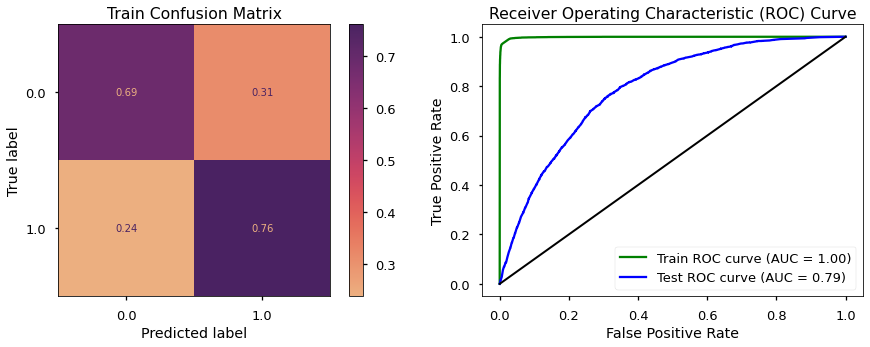

              precision    recall  f1-score   support

         0.0       0.74      0.69      0.71      3543
         1.0       0.71      0.76      0.73      3527

    accuracy                           0.72      7070
   macro avg       0.72      0.72      0.72      7070
weighted avg       0.72      0.72      0.72      7070

Mean Cross Validated Roc_Auc Score: 79%
Train Roc_Auc Score: 100%
Test Roc_Auc Score: 79%
Train Accuracy Score: 98%
Test Accuracy Score: 72%


In [82]:
model_results(rf)

As we can see, the ROC came out way too high, indicating that we are ***way overfitting***, and our testing isn't coming out as well as would be prefered. 

##### Gridsearch Optimization for Random Forrest Model <a id='gscv_rf'></a>

Let's see if we can change our DT parameters to improve our scores. We will use Gridsearch to go thru these parameters to find the most optimal ones to use.

In [85]:
grid = [{'max_depth': [4, 5, 6, 7],
         'min_samples_split': [2, 5, 10],
         'min_samples_leaf': [1, 3, 5]}]

#define the gridsearch
rf_gs = GridSearchCV(estimator=rf,
                          param_grid=grid,
                          scoring='accuracy',
                          cv=5)
#fit the training data
rf_gs.fit(X_train, y_train);

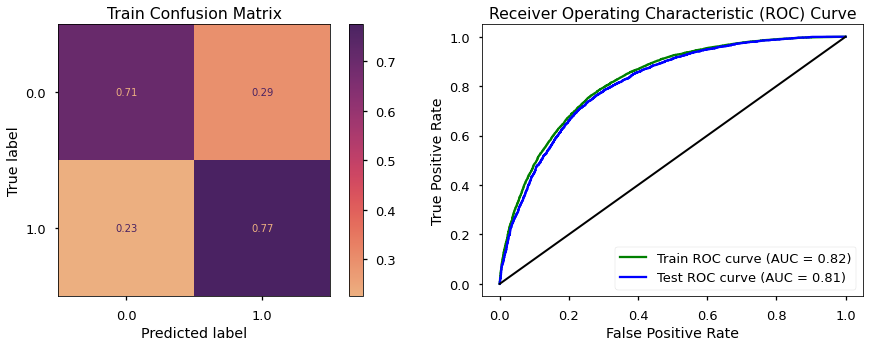

              precision    recall  f1-score   support

         0.0       0.76      0.71      0.73      3543
         1.0       0.72      0.77      0.75      3527

    accuracy                           0.74      7070
   macro avg       0.74      0.74      0.74      7070
weighted avg       0.74      0.74      0.74      7070

Mean Cross Validated Roc_Auc Score: 82%
Train Roc_Auc Score: 82%
Test Roc_Auc Score: 81%
Train Accuracy Score: 75%
Test Accuracy Score: 74%


In [87]:
model_results(rf_gs)

***Considerably better!***

* Our Roc_Auc rose
* Our recall rose for true positives
* Our accuracy rose

Our training scores are still a bit more than our testing scores, so we are overfitting slightly, and our recall for those without diabetes fell, which isn't great. We also really want to improve further to improve the Roc_Auc Score. 

###### Verdict: *GS did improve model for detection of Diabetes*

### Model #3:  XG Boost<a id='xgboost'></a>

XGBoost is short for Extreme Gradient Boost and makes use of regularization parameters that helps against overfitting.

In [86]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
model_results(xgb)

Not a bad start, though overfitting is an issue. Let's refine. 

#### Gridsearch Optimization for XG Boost

In [ ]:
parameters = {
    'n_estimators': [75],              
    'learning_rate': [0.05, 0.1, 0.2],  
    'max_depth': [4, 5, 6],            
    'gamma': [0.5, 1],                 
    'min_child_weight': [3, 4, 5], 
    'subsample': [0.5, 0.75],          
    'colsample_bytree':[0.5, 0.75],
    'random_state':[42]
}

better_xgb = GridSearchCV(estimator = xgb,       
                        param_grid = parameters,     
                        scoring ='roc_auc',          
                        cv = 5,
                        n_jobs = -1
)                      

# Train the pipeline (tranformations & predictor)ui0
better_xgb.fit(X_train, y_train);
model_results(better_xgb)

#### Results
We are overfitting, and accuracy could be better, but recall is not too bad. 

### Model #4: LogitBoost<a id='logit'></a>

LogitBoost is a classifier is a meta-estimator that fits an additive model minimizing a logistic loss function.

In [69]:
lboost = LogitBoost(random_state=42)])
lboost.fit(X_train, y_train)

AttributeError: 'LogitBoost' object has no attribute 'estimators_'

In [ ]:
model_results(lboost)

This is really great! Our mean CV Roc_Auc score is over 80, and our test/train ROC_Auc and Accuracy scores are very close! 

### Feature Importance
While we are here, let's take another look at feature importances.

In [ ]:
lboost.feature_importances_

In [ ]:
(pd.Series(lboost.feature_importances_, index=X.columns)
   .nlargest(15)
   .plot(kind='barh', title="Top 15 Feature Importances of LogitBoost"))

#### Takeaway:

Here we have a plot of the top 15 features. Because some of these features are a result of OHE, they have "x" and then a number for column names. As a reminder, here is a translation: 
* "Age" = x0
* "BMI" = x1
* "GenHlth" = x2

What we can take away from this is that **General Health** (with a scale of 1 being good to 5 being the worst) is the most imporant. While BMI's make a presence on the "top 15", it is not due to having a BMI too high - a BMI of 17 or 18 is actually considered underweight, while a BMI of 22 is considered in the healthy range. While a BMI considered underweight would be helpful in spotting someone who might be prone to disease, it's intruiging to me that a regular, even healthy BMI would have such a high ranking in relation to diabetes. 

Additionally, whether or not someone has had a stroke, has high blood pressure, and difficulty walking have substantial impact on the final outcome. 

## 5. Final Model Selection<a id='final'></a>
Here we will look at our models perfomance next to each other and decide which we will choose.

### Model #1: Logistic Regression After GridSearchCV

In [ ]:
model_results(lr_gs)

##### Why?
* Final model came in with a Mean Cross Validates Roc_Auc Score over 80
* Recall for true positives was higher than any other model
* Overfitting is at a tolerable level

## 6. Business Recommendation:<a id='business'></a>

#### Basic Use Function
When receiving a new patient or even reviewing updated information for a current patient, doctors and nurses would be able to input the basic data points needed for the model to see if a patient might have diabetes (diagnosed or not). This can be implimented into their workflow via an add-on to software they currently use, or as a standalone application. 

#### Recommendation
You will want to keep an eye out for **poor general health, high blood pressure, high cholesterol, elevated BMI, and difficulty walking, especially in older patients.**

While this model can be useful for inputting data on new and existing patients, it shows that the most influental parameters could be examined to utilize in an action plan to improve the patients health.

For example, while someone cannot make themselves younger or erase a stroke from their medical history, they could work to:
* get their BMI to a healthy level
* lower their blood pressure
* take steps to improve their general physical health
* refer to mental health services such as counseling, therapy, etc. as needed

## 7. Going further<a id='further'></a>

I would like to explore the original data from the original dataset (rather than this subset) and do a bit more exploratory analysis on that. This dataset explored pretty broad topics, but I'd like to see if going into more detail in each topic made more of a difference rather than the broad topic on it's own. 

In addition, I would like to explore more data derived not from the patients opinion, but from a measurable quantity outside of that to see if we can get away from possible personal bias. 